<a href="https://colab.research.google.com/github/ChamodKalupahana/simulating_the_universe_using_GANs/blob/main/Conditional_Attention_Residual_U_net_for_N_body_to_hydro_to_generate_unshuffled_evaluation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chamod's Attention Residual U-net model for N-body to M_Z (Unshuffled data)

by adapting https://keras.io/examples/generative/ddim/#denoising-diffusion-implicit-models to include attention blocks

### Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_datasets as tfds
from keras import backend as K
from tensorflow.keras import models, layers, regularizers

N_body_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
hydro_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy' # REMEMBER TO CHECK SAVE FLIE PATH

Mounted at /content/drive


### Hyperparameters

In [ ]:
batch_size = 4
image_size = 256
num_of_epochs = 2

### Define data


In [ ]:
def input_N_body_and_M_Z_IllustrisTNG_data_without_labels():

  global N_body_field_file_path_IllustrisTNG, N_body_field_file_path_SIMBA, hydro_field_file_path_IllustrisTNG, hydro_field_file_path_SIMBA
  # ignore labels for now
  # asinh mean of N_Body_IllustrisTNG dataset = 26.00409
  N_body_dataset = np.arcsinh(np.load(N_body_field_file_path_IllustrisTNG))
  N_body_dataset = np.expand_dims((N_body_dataset) - np.mean(N_body_dataset), axis=3)

  # N_body_dataset_SIMBA = np.arcsinh(np.load(N_body_field_file_path_SIMBA))
  # N_body_dataset_SIMBA = np.expand_dims((N_body_dataset_SIMBA) - np.mean(N_body_dataset_SIMBA), axis=3)

  # N_body_dataset = np.append(N_body_dataset, N_body_dataset_SIMBA, axis=0)

  # np.log10 mean of M_Z_IllustrisTNG dataset = -6.6740975 (np.log10 produces correct lookings maps like in CAMELS examples)
  M_Z_dataset = np.log10(np.load(hydro_field_file_path_IllustrisTNG))
  M_Z_dataset = np.expand_dims((M_Z_dataset) - np.mean(M_Z_dataset), axis=3)

  # M_Z_dataset_SIMBA = np.log10(np.load(hydro_field_file_path_SIMBA))
  # M_Z_dataset_SIMBA = np.expand_dims((M_Z_dataset_SIMBA) - np.mean(M_Z_dataset_SIMBA), axis=3)

  # M_Z_dataset = np.append(M_Z_dataset, M_Z_dataset_SIMBA, axis=0)
  
  #10.089378 for full N-body dataset
  N_body_dataset = N_body_dataset / (np.max(np.abs(N_body_dataset))) # so that pixels are in range [-1,1]
  M_Z_dataset = M_Z_dataset / (np.max(np.abs(M_Z_dataset)))

  full_dataset = tf.data.Dataset.from_tensor_slices((N_body_dataset, M_Z_dataset))

  return full_dataset

ds = input_N_body_and_M_Z_IllustrisTNG_data_without_labels()

In [ ]:
def preprocess_image(train_image, truth_image):
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    train_image = tf.image.resize(train_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    train_image = train_image - tf.keras.backend.min(train_image)
    train_image = train_image / tf.keras.backend.max(train_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    truth_image = tf.image.resize(truth_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    truth_image = truth_image - tf.keras.backend.min(truth_image)
    truth_image = truth_image / tf.keras.backend.max(truth_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    return train_image, truth_image 

x_train = (
    ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    #.shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

(4, 256, 256, 1)


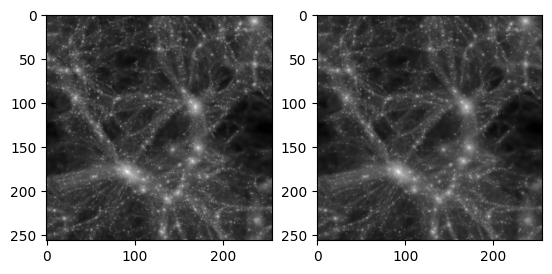

In [ ]:
# check training data
test = tfds.as_numpy(x_train)
test = iter(test)
train_batch, truth_batch = next(test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_batch[0], cmap='gray')
ax[1].imshow(truth_batch[0], cmap='gray')
print(np.shape(truth_batch))

# free up memory
del ds, test

### Define Attention Residual U-net

In [ ]:
def ResidualBlock(width): # from diffusion model
    def apply(x):
        input_width = x.shape[3]
        #print(input_width)
        if input_width == width:
            residual = x
            #print('loop works')
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        #x = layers.Dropout(0.2)(x) # added dropout
        x = layers.Add()([x, residual])
        return x

    return apply

#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=True):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape): # from retina segmentation model
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


def get_attention_residual_model(image_size, widths):
  interpolation = 'bicubic' # define interpolation method for upsampling layers

  # input layer
  input_images = keras.Input(shape=(image_size, image_size, 1))
  x = layers.Conv2D(widths[0], kernel_size=1)(input_images)

  # 1st downsample layer
  x = ResidualBlock(widths[-1])(x) # 128x128
  x = ResidualBlock(widths[-1])(x) # 128x128
  downsample_layer_1 = x # skip connection to attentuate
  x = layers.MaxPooling2D(pool_size=2)(x) # replaced avg pool with max pool (for sharper images)

  # 2nd downsample layer
  x = ResidualBlock(widths[-2])(x) # 96x96
  x = ResidualBlock(widths[-2])(x) # 96x96
  downsample_layer_2 = x
  x = layers.MaxPooling2D(pool_size=2)(x)

  # 3rd downsample layer
  x = ResidualBlock(widths[-2])(x) # 64x64
  x = ResidualBlock(widths[-2])(x) # 64x64
  downsample_layer_3 = x
  x = layers.MaxPooling2D(pool_size=2)(x)

  # 4th downsample layer
  x = ResidualBlock(widths[-3])(x) # 32x32
  x = ResidualBlock(widths[-3])(x) # 32x32
  downsample_layer_4 = x
  x = layers.MaxPooling2D(pool_size=2)(x)

  # 1st Downsampled Residual Block
  x = ResidualBlock(widths[-1])(x)

  # 2nd Downsampled Residual Block
  x = ResidualBlock(widths[-1])(x)
  downsample_layer_5 = x 

  # 1st Upsampling Layer with attention
  gating = gatingsignal(x, 128)
  att = attention_block(downsample_layer_4, gating, 128)
  up = layers.UpSampling2D(size=(2, 2), data_format="channels_last", interpolation=interpolation)(x)
  up = layers.concatenate([up, att], axis=3)
  x = ResidualBlock(128)(up)

  # 2nd Upsampling Layer with attention
  gating = gatingsignal(x, 96)
  att = attention_block(downsample_layer_3, gating, 96)
  up = layers.UpSampling2D(size=(2, 2), data_format="channels_last", interpolation=interpolation)(x)
  up = layers.concatenate([up, att], axis=3)
  x = ResidualBlock(96)(up)

  # 3rd Upsampling Layer with attention
  gating = gatingsignal(x, 64)
  att = attention_block(downsample_layer_2, gating, 64)
  up = layers.UpSampling2D(size=(2, 2), data_format="channels_last", interpolation=interpolation)(x)
  up = layers.concatenate([up, att], axis=3)
  x = ResidualBlock(64)(up)

  # 4th Upsampling Layer with attention
  gating = gatingsignal(x, 32)
  att = attention_block(downsample_layer_1, gating, 32)
  up = layers.UpSampling2D(size=(2, 2), data_format="channels_last", interpolation=interpolation)(x)
  up = layers.concatenate([up, att], axis=3)
  x = ResidualBlock(32)(up)

  # Final output layer
  x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)

  return keras.Model([input_images],x, name="cham-net") # name="attention_residual_unet", boring name

In [ ]:
# network architecture
image_size = 256
widths = [32, 64, 96, 128] # sizes to downsample to (in reverse)

model = get_attention_residual_model(image_size, widths)

In [ ]:
model.summary()

Model: "cham-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  64          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  64         ['conv2d[0][0]']                 
 alization)                     )                                                          

In [ ]:
# Optimiser, adaptive LR scheduler, EarlyStopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
opt = tf.keras.optimizers.experimental.AdamW(weight_decay=0.001, learning_rate=1e-4) # try beta_1 = 0.5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, start_from_epoch=20, restore_best_weights=True, verbose=1)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

checkpoint_path = "256_training_copy/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=2,
                                                 save_best_only=True)

### Training

In [ ]:
# trained for 3 epochs
tf.keras.backend.clear_session()
history = model.fit(x_train, batch_size=4, # use 4 batch size for standard gpu for cham-net
                    epochs=num_of_epochs)

# callbacks=[early_stopping, reduce_lr, cp_callback]

Epoch 1/2
3750/3750 [==============================] - 2835s 745ms/step - loss: 7.0310e-04 - mae: 0.0177
Epoch 2/2
3750/3750 [==============================] - 2847s 759ms/step - loss: 4.9787e-04 - mae: 0.0157


### Test model

1/1 [==============================] - 1s 941ms/step


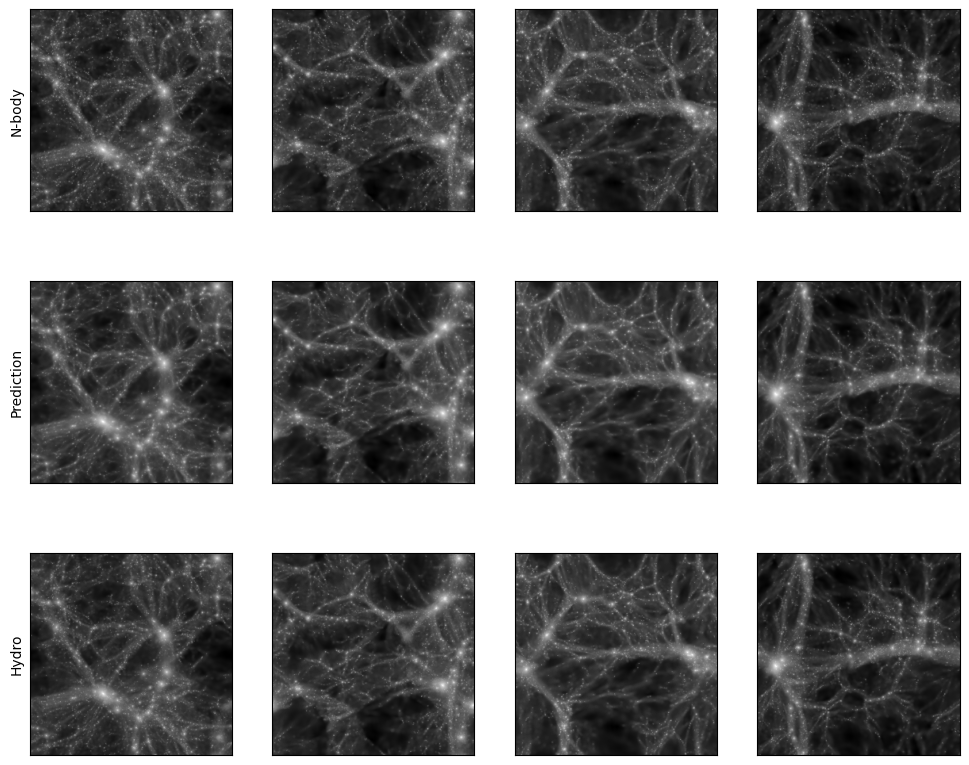

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

N = np.shape(test_batch)[0]
if batch_size > 4:
  N = 4

num_of_images_for_generate = batch_size
generated_images = model.predict(test_batch)


rows = 3
columns = 4
fig, ax = plt.subplots(rows,columns, figsize=(12, 10))
#fig.tight_layout()
#ax[row, column]

for column in range(columns):
    ax[0, column].imshow(test_batch[column], cmap='gray')
    ax[1, column].imshow(generated_images[column], cmap='gray')
    ax[2, column].imshow(truth_batch[column], cmap='gray')

    ax[0, 0].set_ylabel('N-body')
    ax[1, 0].set_ylabel('Prediction')
    ax[2, 0].set_ylabel('Hydro')
    for row in range(rows):
      #ax[row, column].axis("off")
      ax[row, column].set_xticks([])
      ax[row, column].set_yticks([])

### Save images

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

num_of_saved_images = 1000 # must be mutiple of 4 (batch_size)
total_N_body_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_prediction_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_hydro_maps = np.zeros([num_of_saved_images, 256, 256, 1])

for index in range(4, num_of_saved_images, 4):
  generated_images = model.predict(test_batch)

  # save images in arrays
  total_N_body_maps[index-4:index, :,:,:] = test_batch
  total_prediction_maps[index-4:index, :,:,:] = generated_images
  total_hydro_maps[index-4:index, :,:,:] = truth_batch

  test_batch, truth_batch = next(test)


1/1 [==============================] - 0s 184ms/step


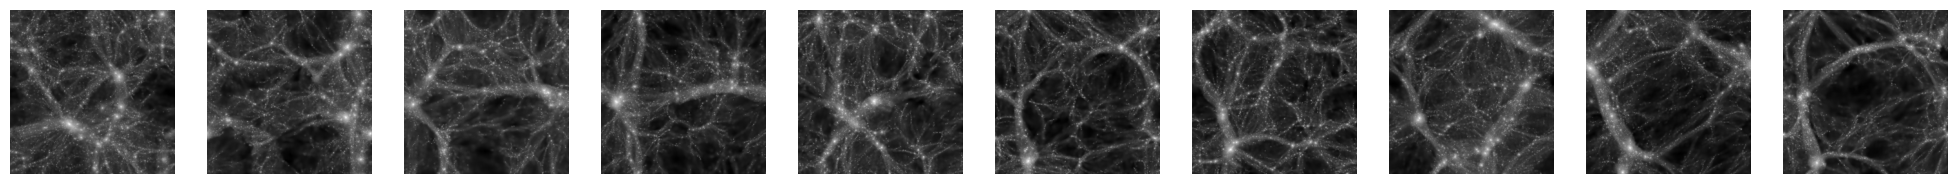

In [ ]:
# n-body graphs should match
columns = 10

fig, ax = plt.subplots(1, columns, figsize=(25, 5))

for column in range(columns):
  ax[column].imshow(total_N_body_maps[column], cmap='gray')
  ax[column].axis('off')

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images', total_N_body_maps)
np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/attention_resdiual_u_net_IllustrisTNG_2_epochs_M_tot_predictions_1000_images', total_prediction_maps)
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_Z_1000_images', total_hydro_maps)